# 04_08_differential_photometry_PS1

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [32]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, sep, aplpy, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module sep is installed
**** module aplpy is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2025-03-03 07:41:40 (KST = GMT+0900) 
0 Python     3.10.16 64bit [GCC 11.2.0]
1 IPython    8.30.0
2 OS         Linux 6.11.0 17 generic x86_64 with glibc2.39
3 numpy      1.26.4
4 pandas     2.2.3
5 matplotlib 3.9.4
6 scipy      1.14.1
7 astropy    6.1.3
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    
13 sep        1.2.1
14 aplpy      2.2.0
15 version_information 1.

This notebook was generated at 2024-09-25 20:50:10 (KST = GMT+0900) 
0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 122 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 119 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 version_information 1.0.4

### import modules

In [33]:
#%%
from glob import glob
from pathlib import Path
import os
import platform
import requests
from datetime import datetime
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities

from astropy.nddata import Cutout2D
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import aperture_photometry as apphot

from astroquery.simbad import Simbad
from urllib.parse import urlencode

from scipy.optimize import curve_fit

import matplotlib
matplotlib.use('Agg')
plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [34]:
#%%
#######################################################
# for log file
log_dir = "logs/"
log_file = "{}{}.log".format(log_dir, '02_06_differential_photometry_PS1')
err_log_file = "{}{}_err.log".format(log_dir, '02_06_differential_photometry_PS1')
print ("log_file: {}".format(log_file))
print ("err_log_file: {}".format(err_log_file))
if not os.path.exists('{0}'.format(log_dir)):
    os.makedirs('{0}'.format(log_dir))
#######################################################

log_file: logs/02_06_differential_photometry_PS1.log
err_log_file: logs/02_06_differential_photometry_PS1_err.log


In [35]:
#%%
count_stars = False
verbose = True
tryagain = True
trynightsky = False
tryASTROMETRYNET = True
file_age = 60
file_retry_dt = datetime(2025, 3, 1, 15)
downsample = 4
verbose = True

In [36]:
#%%
#######################################################
BASEDIR = Path("/mnt/Rdata/ASTRO_data") 
if platform.system() == "Windows":
    BASEDIR = Path("R:\\ASTRO_data")  

PROJECDIR = BASEDIR / "C1-Variable"
TODODIR = PROJECDIR / "-_-_-_2016-_-_RiLA600_STX-16803_-_2bin"      # finished
# TODODIR = PROJECDIR / "-_-_-_2017-01_-_RiLA600_STX-16803_-_2bin"    # finished
# TODODIR = PROJECDIR / "-_-_-_2017-03_-_RiLA600_STX-16803_-_2bin"    # finished
# TODODIR = PROJECDIR / "-_-_-_2017-05_-_RiLA600_STX-16803_-_2bin"    # finished
# TODODIR = PROJECDIR / "-_-_-_2017-06_-_RiLA600_STX-16803_-_2bin"    # finished
# TODODIR = PROJECDIR / "-_-_-_2021-10_-_RiLA600_STX-16803_-_2bin"    # finished
# TODODIR = PROJECDIR / "-_-_-_2022-01_-_RiLA600_STX-16803_-_2bin"    # finished

# PROJECDIR = BASEDIR / "C2-Asteroid"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2022-_-_RiLA600_STX-16803_-_2bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "-_-_-_2023-_-_RiLA600_STX-16803_-_2bin"

# PROJECDIR = BASEDIR / "C3-EXO"
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_GSON300_STF-8300M_-_1bin"  # finished
# TODODIR = PROJECDIR / "-_-_-_2024-05_-_RiLA600_STX-16803_-_1bin"  # finished
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_GSON300_STF-8300M_-_1bin"  # finished
# TODODIR = PROJECDIR / "-_-_-_2024-06_-_RiLA600_STX-16803_-_2bin"  # -1
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_GSON300_STF-8300M_-_1bin" # =1
# TODODIR = PROJECDIR / "-_-_-_2024-09_-_RiLA600_ASI6200MMPro_-_2bin"  # to do
# TODODIR = PROJECDIR / "-_-_-_2024-11_-_GSON300_STF-8300M_-_1bin"    # to do
# TODODIR = PROJECDIR / "-_-_-_2024-11_-_RiLA600_ASI6200MMPro_-_3bin" # to do
# TODODIR = PROJECDIR / "-_-_-_2025-01_-_GSON300_STF-8300M_-_1bin"  # to do
# TODODIR = PROJECDIR / "-_-_-_2025-01_-_RiLA600_ASI6200MMPro_-_3bin"  # to do
# TODODIR = PROJECDIR / "-_-_-_2025-02_-_GSON300_STF-8300M_-_1bin"  # to do
# TODODIR = PROJECDIR / "-_-_-_2025-02_-_RiLA600_ASI6200MMPro_-_3bin"  # to do

# PROJECDIR = BASEDIR / "C4-Spectra"
# TODODIR = PROJECDIR / "-_-_-_2024-05_TEC140_ASI183MMPro_-_1bin"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
if verbose == True :
    print ("DOINGDIRs: ", format(DOINGDIRs))
    print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

try : 
    BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
    print ("BDFDIR: ", format(BDFDIR))
    MASTERDIR = Path(BDFDIR[0]) / _astro_utilities.master_dir
    if not MASTERDIR.exists():
        os.makedirs("{}".format(str(MASTERDIR)))
        print("{} is created...".format(str(MASTERDIR)))
    print ("MASTERDIR: ", format(MASTERDIR))
except Exception as err :
    print("X"*60)
    _Python_utilities.write_log(err_log_file, f'''{fpath}, {str(err)}''', verbose=verbose)
    pass

filter_strs = ['LIGHT',
                # '2025-02',
                # 'GPX-1b',
                # 'HAT',
                # 'WASP',
                ]  # Example list of filter strings
DOINGDIRs = [x for x in DOINGDIRs if all(filter_str in str(x) for filter_str in filter_strs)]

rm_filter_strs = [
                # 'GPX-1b',
                # 'HAT',
                # 'WASP',
                # 'Bad_fits', 
                #   'Another_bad_string',
                  ]  # Example list of filter strings to remove
DOINGDIRs = [x for x in DOINGDIRs if not any(rm_filter_str in str(x) for rm_filter_str in rm_filter_strs)]

if verbose == True :
    print ("DOINGDIRs: ", DOINGDIRs)
    print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  ['/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2016-09_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-08_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-09_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-13_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-11-08_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-11-11_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LI

In [37]:
#%%
#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
GSHS =  EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')
#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 4

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_target = 12.5
Mag_delta_INIT = 2
ERR_Minimum = 0.5

coord_deltas = np.arange(0.00001, 0.00050, 0.00001)
#######################################################


In [38]:
#%%
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    if verbose == True :
        print("DOINGDIR", DOINGDIR)

    foldername_el = DOINGDIR.parts[-1].split("_")
    targ_name = foldername_el[0]
    targ_name = targ_name.replace("-"," ")

    obsdate = foldername_el[3]
    bin = foldername_el[-1][0]
    
    if verbose == True :
        print("targ_name :", targ_name)
        print("obsdate :", obsdate)
        print("bin :", bin)

    if DOINGDIR.parts[-3] == "C1-Variable" :
        targ_info = _astro_utilities.get_variable_star_info(targ_name, verbose=verbose)
        if targ_info:
            print(f"Variable Star Info for {targ_name}:")
            for key, value in targ_info.items():
                print(f"{key}: {value}")
            star_name = targ_info['Star Name']
            star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
            print(type(star_info))
        else:
            print(f"No information found for {targ_name}.")

    if DOINGDIR.parts[-3] == "C3-EXO" :
        nasa_exoplanet_archive = _astro_utilities.NASAExoplanetArchive()
        targ_info = nasa_exoplanet_archive.get_exoplanet_orbital_info(targ_name)
        if targ_info:
            print(f"Orbital information for {targ_name}:")
            for key, value in targ_info.items():
                print(f"{key}: {value}")
            star_name = targ_info['hostname']
            star_name = star_name.replace("-"," ")
            star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
            print(type(star_info))
            # try :
            #     Mag_target = int(star_info['V Magnitude'])  # Convert the average magnitude to an integer
            # except :
            #     pass
            # if Mag_target <= 12 : 
            #     Mag_target = 12
            # elif Mag_target >= 15 :
            #     Mag_target = 15
        else:
            print(f"No orbital information found for {targ_name}.")
    df_targ = pd.DataFrame([star_info])
    if verbose == True:
        print(f"starname: {star_name}")
        print("Mag_target:", Mag_target)
        print("star_info:", star_info)
        print("df_targ:", df_targ)

    READINGDIR = DOINGDIR / _astro_utilities.reduced_dir
    # READINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir

    DIFFPRESULTDIR = DOINGDIR / f"{READINGDIR.parts[-1]}_DPhot_target_Mag{Mag_target}_fw{FWHM_INIT}"
    if not DIFFPRESULTDIR.exists():
        os.makedirs("{}".format(str(DIFFPRESULTDIR)))
        if verbose == True :
            print("{} is created...".format(str(DIFFPRESULTDIR)))

    summary = yfu.make_summary(READINGDIR/"*.fit*",
                                    verify_fix=True,
                                    ignore_missing_simple=True,
                                    verbose = verbose,)
    if summary is not None : 
        if verbose == True :
            print("len(summary):", len(summary))
            #print("summary:", summary)
            #print(summary["file"][0])
        df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        if verbose == True :
            print("df_light:\n{}".format(df_light))

        for _, row  in df_light.iterrows():

            fpath = Path(row["file"])

            DOIT = False
            check_fpath = (DIFFPRESULTDIR/f"{fpath.stem}_result_photometry.csv")
            if not check_fpath.exists() :
                DOIT = True
                if verbose == True :
                    print("*"*10)
                    print("*"*10)
                    print(f"{check_fpath} is not exist...")                
            else :
                if tryagain == True and (_Python_utilities.is_file_created_before(check_fpath, file_retry_dt)):
                    DOIT = True
                    if verbose == True :
                        print("*"*10)
                        print("*"*10)
                        print("*"*10)
                        print(f"{check_fpath} is older than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
                else :
                    if verbose == True :
                        print("*"*10)
                        print(f"{check_fpath} is younger than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
                    pass
            if DOIT :   

                if verbose == True :
                    print("*"*20)
                    print(f"Starting {fpath.name}...")
                hdul = fits.open(fpath)
                ccd = yfu.load_ccd(fpath)
                flt = hdul[0].header["filter"]

                SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
                print(SOLVE, ASTAP, LOCAL)

DOINGDIR /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin
targ_name : BL CAM
obsdate : 2016-10-03
bin : 2
Variable Star Info for BL CAM:
Star Name: BL CAM
RA: 03 47 19.82
DEC: +63 22 42.6
Magnitude: None
Variability Type: SXPHE
Period: 0.03909844
Epoch: None
Variable Star Info for BL CAM:
Star Name: BL CAM
RA: 03 47 19.82
DEC: +63 22 42.6
Magnitude: None
Variability Type: SXPHE
Period: 0.03909844
Epoch: None
result: MAIN_ID       RA           DEC      ...   PMDEC   PLX_VALUE SCRIPT_NUMBER_ID
           "h:m:s"       "d:m:s"    ...  mas / yr    mas                    
------- ------------- ------------- ... --------- --------- ----------------
 GD 428 03 47 19.8773 +63 22 42.150 ...   -28.887     1.472                1
Star Info for BL CAM:
Star Name: BL CAM
RA: 03 47 19.8773
DEC: +63 22 42.150
V Magnitude: --
Proper Motion RA: 123.531
Proper Motion Dec: -28.887
Parallax: 1.4725
<class 'dict'>
starname: BL CAM


In [39]:
#%%
DOINGDIR = Path(DOINGDIRs[0])
if verbose == True :
    print("DOINGDIR", DOINGDIR)

foldername_el = DOINGDIR.parts[-1].split("_")
targ_name = foldername_el[0]
targ_name = targ_name.replace("-"," ")

obsdate = foldername_el[3]
bin = foldername_el[-1][0]

if verbose == True :
    print("targ_name :", targ_name)
    print("obsdate :", obsdate)
    print("bin :", bin)

# if DOINGDIR.parts[-3] == "C1-Variable" :
#     targ_info = _astro_utilities.get_variable_star_info(targ_name, verbose=verbose)
#     if targ_info:
#         print(f"Variable Star Info for {targ_name}:")
#         for key, value in targ_info.items():
#             print(f"{key}: {value}")
#         star_name = targ_info['Star Name']
#         star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
#         print(type(star_info))
#     else:
#         print(f"No information found for {targ_name}.")

# if DOINGDIR.parts[-3] == "C3-EXO" :
#     nasa_exoplanet_archive = _astro_utilities.NASAExoplanetArchive()
#     targ_info = nasa_exoplanet_archive.get_exoplanet_orbital_info(targ_name)
#     if targ_info:
#         print(f"Orbital information for {targ_name}:")
#         for key, value in targ_info.items():
#             print(f"{key}: {value}")
#         star_name = targ_info['hostname']
#         star_name = star_name.replace("-"," ")
#         star_info = _astro_utilities.get_star_info(star_name, verbose=verbose)
#         print(type(star_info))
#         # try :
#         #     Mag_target = int(star_info['V Magnitude'])  # Convert the average magnitude to an integer
#         # except :
#         #     pass
#         # if Mag_target <= 12 : 
#         #     Mag_target = 12
#         # elif Mag_target >= 15 :
#         #     Mag_target = 15
#     else:
#         print(f"No orbital information found for {targ_name}.")
# df_targ = pd.DataFrame([star_info])
# if verbose == True:
#     print(f"starname: {star_name}")
#     print("Mag_target:", Mag_target)
#     print("star_info:", star_info)
#     print("df_targ:", df_targ)

READINGDIR = DOINGDIR / _astro_utilities.reduced_dir
# READINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir

DIFFPRESULTDIR = DOINGDIR / f"{READINGDIR.parts[-1]}_DPhot_target_Mag{Mag_target}_fw{FWHM_INIT}"
if not DIFFPRESULTDIR.exists():
    os.makedirs("{}".format(str(DIFFPRESULTDIR)))
    if verbose == True :
        print("{} is created...".format(str(DIFFPRESULTDIR)))

summary = yfu.make_summary(READINGDIR/"*.fit*",
                                verify_fix=True,
                                ignore_missing_simple=True,
                                verbose = verbose,)
if summary is not None : 
    if verbose == True :
        print("len(summary):", len(summary))
        #print("summary:", summary)
        #print(summary["file"][0])
    df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
    df_light = df_light.reset_index(drop=True)
    if verbose == True :
        print("df_light:\n{}".format(df_light))

    for _, row  in df_light.iterrows():

        fpath = Path(row["file"])

        DOIT = False
        check_fpath = (DIFFPRESULTDIR/f"{fpath.stem}_result_photometry.csv")
        if not check_fpath.exists() :
            DOIT = True
            if verbose == True :
                print("*"*10)
                print("*"*10)
                print(f"{check_fpath} is not exist...")                
        else :
            if tryagain == True and (_Python_utilities.is_file_created_before(check_fpath, file_retry_dt)):
                DOIT = True
                if verbose == True :
                    print("*"*10)
                    print("*"*10)
                    print("*"*10)
                    print(f"{check_fpath} is older than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
            else :
                if verbose == True :
                    print("*"*10)
                    print(f"{check_fpath} is younger than {file_retry_dt.strftime('%Y-%m-%d %H:%M:%S')}...")
                pass
        if DOIT :   

            if verbose == True :
                print("*"*20)
                print(f"Starting {fpath.name}...")
            hdul = fits.open(fpath)
            ccd = yfu.load_ccd(fpath)
            flt = hdul[0].header["filter"]

            SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
            print(SOLVE, ASTAP, LOCAL)

DOINGDIR /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin
targ_name : BL CAM
obsdate : 2016-10-03
bin : 2
All 100 keywords (guessed from /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin/reduced/BL-CAM_LIGHT_V_2016-10-03-16-51-38_80sec_RiLA600_STX-16803_-19c_2bin.fit) will be loaded.
len(summary): 125
df_light:
                                                  file  filesize  SIMPLE  \
0    /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_...  16842240    True   
1    /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_...  16842240    True   
2    /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_...  16842240    True   
3    /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_...  16842240    True   
4    /mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_...  16842240    True   
..                                                 ...       ...     ...   
12

In [40]:
if SOLVE :
    wcs = WCS(hdul[0].header)
    # It is used as a rough estimate, so no need to be accurate:
    #PIX2ARCSEC = 0.62*u.arcsec
    if 'PIXSCALE' in hdul[0].header:
        PIX2ARCSEC = hdul[0].header['PIXSCALE']
    else : 
        PIX2ARCSEC = _astro_utilities.calPixScale(hdul[0].header['FOCALLEN'], 
                                        hdul[0].header['XPIXSZ'],
                                        hdul[0].header['XBINNING'])
        
    if hdul[0].header['CCDNAME'] == 'STX-16803' :
        val_figsize=(10, 9)
        val_fraction = 0.0455
    else :
        val_figsize=(12, 9)
        val_fraction = 0.0035

    # It is used as a rough estimate, so no need to be accurate:
    PIX2ARCSEC = hdul[0].header["PIXSCALE"]
    
    if "EGAIN" in hdul[0].header :
        gain = hdul[0].header["EGAIN"]
    elif "GAIN" in hdul[0].header :
        gain = hdul[0].header["GAIN"]
    else :  
        gain = _astro_utilities.CCDDIC[hdul[0].header["CCDNAME"]]["GAIN"]

    if "RDNOISE" in hdul[0].header :
        rdnoise = hdul[0].header["RDNOISE"]
    else :
        rdnoise = _astro_utilities.CCDDIC[hdul[0].header["CCDNAME"]]["RDNOISE"]
    if verbose == True :
        print(f"gain : {gain},  rdnoise : {rdnoise},  PIX2ARCSEC : {PIX2ARCSEC}")
    
    # D.2. Find the observation time and exposure time to set the obs time
    t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
    t_expos = hdul[0].header['EXPTIME'] * u.s
    t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
    if verbose == True :
        print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")
    
    # Get the radius of the smallest circle which encloses all the pixels
    rad = yfu.fov_radius(header=hdul[0].header,
                        unit=u.deg)
    cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                        center_of_image=True)
    pos_sky = SkyCoord(cent_coord, unit='deg')
    pos_pix = pos_sky.to_pixel(wcs=wcs)
    
    if verbose == True :
        print("rad: {}".format(rad))  # 시야각(FOV)으로 구한 반지름
        print("cent_coord: {}".format(cent_coord))
        print("pos_sky: {}".format(pos_sky))
        print("pos_pix: {}".format(pos_pix))

gain : 2.54,  rdnoise : 9.0,  PIX2ARCSEC : 2.47518
t_start: 2016-10-03T20:54:45.000, t_expos: 100.0 s, t_middle: 2016-10-03T20:55:35.000
rad: 0.353365832948841 deg
cent_coord: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (56.88365331, 63.32307539)>
pos_sky: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (56.88365331, 63.32307539)>
pos_pix: (array(1023.5), array(1023.5))


In [41]:
#%%                        
try :
    Mag_delta = Mag_delta_INIT
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

    if len(PS1_stars_all) < 10 :
        Mag_delta = Mag_delta_INIT + 2
        ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                    column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                    "e_rmag":"<0.10", "nr":">5"})
        PS1_stars_all = ps1.query()
        
except :
    Mag_delta = Mag_delta_INIT + 2
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

if verbose == True :
    print("type(PS1_stars_all) :", type(PS1_stars_all))
    print("len(PS1_stars_all) :", len(PS1_stars_all))

isnear = ypu.organize_ps1_and_isnear(
                    ps1, 
                    # header=ccd.header+ccd.wcs.to_header(), 
                    ccd.header+ccd.wcs.to_header(), 
                    # bezel=5*FWHM_INIT*PIX2ARCSEC.value,
                    # nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC.value,
                    bezel=5*FWHM_INIT*PIX2ARCSEC,
                    nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC,
                    group_crit_separation=6*FWHM_INIT
                )
df_stars_all = PS1_stars_all.to_pandas()
df_stars = ps1.queried.to_pandas()
# print("len(df_stars):", len(df_stars))
df_stars = df_stars.dropna(subset=["gmag", "rmag"])
if len(df_stars) > 100 :
    df_stars = df_stars[:100]
if verbose == True :
    print("len(df_stars_all):", len(df_stars_all))
    print("len(df_stars):", len(df_stars))

pos_stars_all = np.array([df_stars_all["RAJ2000"].array, df_stars_all["DEJ2000"].array]).T
pos_stars_all = SkyCoord(pos_stars_all, **SKYC_KW).to_pixel(wcs)
pos_stars_all = np.transpose(pos_stars_all)
# pos_stars_all   # PS1 query 모든 별

pos_stars = np.array([df_stars["RAJ2000"].array, df_stars["DEJ2000"].array]).T
pos_stars = SkyCoord(pos_stars, **SKYC_KW).to_pixel(wcs)
pos_stars = np.transpose(pos_stars)
# pos_stars     # PS1 query 중 비교 측광에 사용될 별

type(PS1_stars_all) : <class 'astropy.table.table.Table'>
len(PS1_stars_all) : 177
177 objects remaining:   0 masked out of 177 based on [49.5036 49.5036]-pixel bezel.
161 objects remaining:  16 masked out of 177 based on DAOGROUP with 24.000-pixel critical separation..
159 objects remaining:   2 masked out of 161 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
111 objects remaining:  48 masked out of 159 based on the Kron magnitude criterion.
len(df_stars_all): 177
len(df_stars): 100


In [42]:



#%%                        
try :
    Mag_delta = Mag_delta_INIT
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

    if len(PS1_stars_all) < 10 :
        Mag_delta = Mag_delta_INIT + 2
        ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                    column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                    "e_rmag":"<0.10", "nr":">5"})
        PS1_stars_all = ps1.query()
        
except :
    Mag_delta = Mag_delta_INIT + 2
    ps1 = ypu.PanSTARRS1(cent_coord.ra, cent_coord.dec, radius=rad,
                column_filters={"rmag":f"{Mag_target-Mag_delta}..{Mag_target+Mag_delta}",
                "e_rmag":"<0.10", "nr":">5"})
    PS1_stars_all = ps1.query()

if verbose == True :
    print("type(PS1_stars_all) :", type(PS1_stars_all))
    print("len(PS1_stars_all) :", len(PS1_stars_all))

isnear = ypu.organize_ps1_and_isnear(
                    ps1, 
                    # header=ccd.header+ccd.wcs.to_header(), 
                    ccd.header+ccd.wcs.to_header(), 
                    # bezel=5*FWHM_INIT*PIX2ARCSEC.value,
                    # nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC.value,
                    bezel=5*FWHM_INIT*PIX2ARCSEC,
                    nearby_obj_minsep=5*FWHM_INIT*PIX2ARCSEC,
                    group_crit_separation=6*FWHM_INIT
                )
df_stars_all = PS1_stars_all.to_pandas()
df_stars = ps1.queried.to_pandas()
# print("len(df_stars):", len(df_stars))
df_stars = df_stars.dropna(subset=["gmag", "rmag"])
# if len(df_stars) > 300 :
#     df_stars = df_stars[:300]
if verbose == True :
    print("len(df_stars_all):", len(df_stars_all))
    print("len(df_stars):", len(df_stars))

pos_stars_all = np.array([df_stars_all["RAJ2000"].array, df_stars_all["DEJ2000"].array]).T
pos_stars_all = SkyCoord(pos_stars_all, **SKYC_KW).to_pixel(wcs)
pos_stars_all = np.transpose(pos_stars_all)
# pos_stars_all   # PS1 query 모든 별

pos_stars = np.array([df_stars["RAJ2000"].array, df_stars["DEJ2000"].array]).T
pos_stars = SkyCoord(pos_stars, **SKYC_KW).to_pixel(wcs)
pos_stars = np.transpose(pos_stars)
# pos_stars     # PS1 query 중 비교 측광에 사용될 별

ap_stars = CAp(positions=pos_stars, r=R_IN)
ap_stars_all = CAp(positions=pos_stars_all, r=R_IN)

#apert
an_stars = CAn(positions=pos_stars, r_in=R_IN, r_out=R_OUT)
an_stars_all = CAn(positions=pos_stars_all, r_in=R_IN, r_out=R_OUT)

#%%
# pos_pix_targ_init = SkyCoord(df_targ["ra"].values, df_targ["dec"].values, **SKYC_KW).to_pixel(wcs)
pos_sky_targ_init = SkyCoord(df_targ["RA"].values, df_targ["DEC"].values, 
                            unit=(u.hourangle, u.deg),
                            frame='icrs')

# pos_pix_targ_init = pos_sky_targ_init.to_pixel(wcs)

# ap_targ = CAp([pos_pix_targ_init[0][0], pos_pix_targ_init[1][0]], r=R_AP)
# an_targ = CAn([pos_pix_targ_init[0][0], pos_pix_targ_init[1][0]], r_in=R_IN, r_out=R_OUT)

# phot_targ = ypu.apphot_annulus(hdul[0].data, 
#                             ap_targ, an_targ, error=yfu.errormap(hdul[0].data))

# if verbose==True :
#     print("pos_pix_targ_init:", pos_pix_targ_init)
#     print("ap_targ:", ap_targ)
#     print("an_targ:", an_targ)
#     print("phot_targ:", phot_targ)

type(PS1_stars_all) : <class 'astropy.table.table.Table'>
len(PS1_stars_all) : 177
177 objects remaining:   0 masked out of 177 based on [49.5036 49.5036]-pixel bezel.
161 objects remaining:  16 masked out of 177 based on DAOGROUP with 24.000-pixel critical separation..
159 objects remaining:   2 masked out of 161 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
111 objects remaining:  48 masked out of 159 based on the Kron magnitude criterion.
len(df_stars_all): 177
len(df_stars): 111


In [43]:
#%%
#####################################################
# Plotting #2 f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png"
#####################################################
fig, axs = plt.subplots(1, 1, figsize=val_figsize,
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, ccd, )

ap_stars_all.plot(axs, color='w', lw=1)
# ap_stars.plot(axs, color='r', lw=1)

# ap_targ.plot(axs, color="r")
# if an_targ is not None:
#     an_targ.plot(axs, color="r")

_phot_stars = []

for i, row in df_stars.iterrows():
    pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"], **SKYC_KW).to_pixel(wcs)
    ap = CAp([pos_star[0], pos_star[1]], r=R_IN)
    an = CAn([pos_star[0], pos_star[1]], r_in=R_IN, r_out=R_OUT)
    _phot_star = ypu.apphot_annulus(ccd, ap, an, error=yfu.errormap(ccd))
    _phot_star[f"{flt}mag"] = row[f"{flt}mag"]
    _phot_star[f"e_{flt}mag"] = row[f"e_{flt}mag"]
    _phot_star["gmag"] = row["gmag"]
    _phot_star["e_gmag"] = row["e_gmag"]
    _phot_star["rmag"] = row["rmag"]
    _phot_star["e_rmag"] = row["e_rmag"]
    _phot_star["grcolor"] = row["grcolor"]
    _phot_star["e_grcolor"] = row["e_grcolor"]
    _phot_star["id"] = i
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    axs.text(pos_star[0]+10, pos_star[1]+10, f"star {i}:{row[f'{flt}mag']:.01f}", fontsize=8, color="w")
    ap.plot(axs, color="orange")

axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('b')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('l')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')

axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

cbar = plt.colorbar(im, ax=axs, fraction=0.035, pad=0.04)

axs.set_title(f"fname: {fpath.name}\n {targ_name} : {flt} ${{{flt}}}_{{PS1}}$ of comparison stars (PS1 query : ${{{Mag_target}}} \pm {{{Mag_delta}}})", fontsize=10)
axs.annotate(f'Number of comparison star(s): {len(pos_stars)}\nNumber of all PS1 star(s): {len(pos_stars_all)}', fontsize=8,
            xy=(0, 0), xytext=(10, -20), va='top', ha='left',
            xycoords='axes fraction', textcoords='offset points')
# if phot_targ is not None :
#     axs.annotate(f"{targ_name}\n${{{flt}}}_{{inst}} = {{{phot_targ['mag'][0]:+.03f}}} \pm {{{phot_targ['merr'][0]:.03f}}}$\nsnr: {phot_targ['snr'][0]:.02f}", fontsize=8,
#             xy=(1, 0), xytext=(-100, -20), va='top', ha='left',
#             xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png")
if verbose == True :
    print(f"{DIFFPRESULTDIR}/{fpath.stem}_PS1_magnitude.png is created...")
    
# plt.show()
plt.clf()
plt.close('all')

/mnt/Rdata/ASTRO_data/C1-Variable/-_-_-_2016-_-_RiLA600_STX-16803_-_2bin/BL-CAM_LIGHT_-_2016-10-03_-_RiLA600_STX-16803_-_2bin/reduced_DPhot_target_Mag12.5_fw4/BL-CAM_LIGHT_V_2016-10-03-20-54-45_100sec_RiLA600_STX-16803_-19c_2bin_PS1_magnitude.png is created...


In [ ]:
# # Check if ap_targ exists
# try:
#     _phot_stars = _astro_utilities.plot_ps1_magnitude(hdul, wcs, df_stars, pos_stars_all, 
#                                                             pos_stars, ap_stars_all, 
#                                                             fpath, targ_name, flt, Mag_target, Mag_delta, 
#                                                             DIFFPRESULTDIR, val_figsize, SKYC_KW, R_IN, R_OUT, 
#                                                             an_targ=an_targ, phot_targ=phot_targ, 
#                                                             verbose=True)
#     print("ap_targ exists")
# except NameError:
#     _phot_stars = _astro_utilities.plot_ps1_magnitude(hdul, wcs, df_stars, pos_stars_all, 
#                                                             pos_stars, ap_stars_all, 
#                                                             fpath, targ_name, flt, Mag_target, Mag_delta, 
#                                                             DIFFPRESULTDIR, val_figsize, SKYC_KW, R_IN, R_OUT, 
#                                                             verbose=True)
#     print("ap_targ does not exist")

/mnt/Rdata/ASTRO_data/C3-EXO/-_-_-_2024-09_-_GSON300_STF-8300M_-_1bin/HAT-P-16b_LIGHT_-_2024-10-01_-_GSON300_STF-8300M_-_1bin/reduced_DPhot_target_Mag12.5_fw4/HAT-P-16b_LIGHT_V_2024-10-01-20-43-46_100sec_GSON300_STF-8300M_13c_1bin_PS1_magnitude.png is created...
ap_targ does not exist


In [47]:
#%%
######################################################
## Plotting #3 calculate error
######################################################
df_phot_stars = pd.concat(_phot_stars)
df_phot_stars_na = df_phot_stars.dropna()
if verbose == True :
    print("len(df_phot_stars_na):", len(df_phot_stars_na))
    print("df_phot_stars_na:\n", df_phot_stars_na)
    print("df_phot_stars_na.columns:", df_phot_stars_na.columns)
    print("df_phot_stars_na['merr']:", df_phot_stars_na['merr'])

df_phot_stars_na = df_phot_stars_na[df_phot_stars_na["merr"] < ERR_Minimum]
df_phot_stars_na = df_phot_stars_na.set_index('id', drop=True)
df_phot_stars_na = df_phot_stars_na.reset_index()
if verbose == True :
    print("len(df_phot_stars_na):", len(df_phot_stars_na))
    print("df_phot_stars_na:\n", df_phot_stars_na)

merr_total1 = np.sqrt((df_phot_stars_na["merr"])**2 + (df_phot_stars_na[f"e_{flt}mag"])**2)

# === Calculate zero point and errors
_xx = np.linspace(Mag_target-Mag_delta, Mag_target+Mag_delta)
zeropt_med = np.median(df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"])
# zeropt_avg = np.average(df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
#                         weights=1/merr_total1**2)
dzeropt = np.max([1/np.sqrt(np.sum(1/(merr_total1)**2)),
                np.std((df_phot_stars_na[f"e_{flt}mag"] - df_phot_stars_na["merr"]), ddof=1)/np.sqrt(len(df_phot_stars_na[f"{flt}mag"]))])
merr_total2 = np.sqrt(np.sqrt(merr_total1**2 + dzeropt**2))

# === Find fitting lines
# Search for the usage of scipy.optimize.curve_fit.
# poptm, _ = curve_fit(_astro_utilities.linf, df_phot_stars_na[f"{flt}mag"],
#                     df_phot_stars_na["mag"],
#                     sigma= df_phot_stars_na["merr"], absolute_sigma=True)
# poptc, _ = curve_fit(_astro_utilities.linf, df_phot_stars_na["grcolor"],
#                     df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
#                     sigma=merr_total2, absolute_sigma=True)

errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

def plot_common(ax, x, y, xerr, yerr, title="", xlabel="", ylabel="", ylim=None):
    ax.plot(x, y, '+')
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, **errkw)
    ax.axhline(zeropt_med, color="r", lw=1, label=f"$Z = {{{zeropt_med:.3f}}} ± {{{dzeropt:.3f}}}$\n(median value)")
    # ax.axhline(zeropt_avg, color="b", lw=1, label=f"$Z = {{{zeropt_avg:.3f}}} ± {{{dzeropt:.3f}}}$\n(average value)")
    ax.hlines([zeropt_med + dzeropt, zeropt_med - dzeropt, 
                # zeropt_avg + dzeropt, zeropt_avg - dzeropt
                ],
            *ax.get_xlim(), color=["r","r","b","b"], lw=1, ls=":")
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel, ylim=ylim)
    # ax.legend(fontsize=8, loc='best')


len(df_phot_stars_na): 101
df_phot_stars_na:
      id      xcenter      ycenter  aperture_sum  aperture_sum_err      msky  \
0     0  1041.370191   997.273923   1558.338821         39.475800  1.935028   
0     1  1102.859853   918.663102   1560.380599         39.501653  1.935454   
0     2   991.275798   881.506002   1559.083384         39.485230  1.937672   
0     3   946.173933   881.753540   1558.364589         39.476127  1.935666   
0     4  1129.281941  1148.344531   1556.868716         39.457176  1.932815   
..  ...          ...          ...           ...               ...       ...   
0   105  1862.556734  1556.176739   1543.131262         39.282709  1.916861   
0   106   492.981565   177.202741   1530.765834         39.125003  1.902886   
0   107   603.196294   115.113150   1533.092573         39.154726  1.903292   
0   108   150.242996  1530.113457   1532.979067         39.153277  1.903956   
0   109   618.999592  1949.368336   1537.637243         39.212718  1.909291   

     

In [45]:
df_phot_stars_na["merr"]

Series([], Name: merr, dtype: float64)

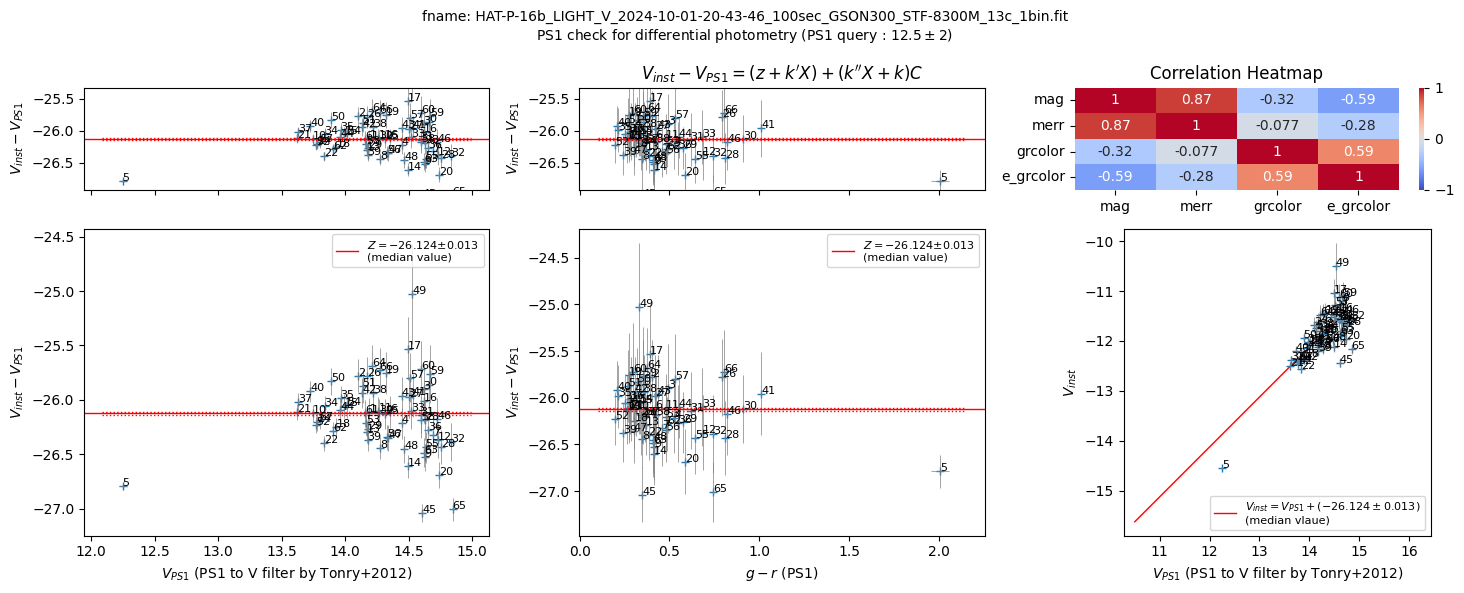

In [12]:
#####################################################
# Plotting #4 f"{DIFFPRESULTDIR}/{fpath.stem}_standardization.png"
#####################################################
errkw = dict(marker="", ls="", ecolor="gray", elinewidth=0.5)

fig, axs = plt.subplots(2, 3, figsize=(15, 6), sharex=False, sharey=False,
                gridspec_kw={'height_ratios': [1, 3]})

# 상단 행
plot_common(axs[0, 0], df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_{flt}mag"], df_phot_stars_na["merr"],
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
            ylim=(zeropt_med-0.8, zeropt_med+0.8))

plot_common(axs[0, 1], df_phot_stars_na["grcolor"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_grcolor"], merr_total2,
            title=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}} = (z + k'X) + (k''X + k)C$",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$",
            ylim=(zeropt_med-0.8, zeropt_med+0.8))
# axs[0, 1].plot(axs[0, 1].get_xlim(), _astro_utilities.linf(np.array(axs[0, 1].get_xlim()), *poptc),
#             "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
# axs[0, 1].legend(fontsize=8, loc='best')

data = df_phot_stars_na[["mag", "merr", "grcolor", "e_grcolor"]]
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axs[0, 2])
axs[0, 2].set(title='Correlation Heatmap')

# 하단 행
plot_common(axs[1, 0], df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_{flt}mag"], df_phot_stars_na["merr"],
            xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")

plot_common(axs[1, 1], df_phot_stars_na["grcolor"], df_phot_stars_na["mag"] - df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na[f"e_grcolor"], merr_total2,
            xlabel="$g - r$ (PS1)",
            ylabel=f"${{{flt}}}_{{inst}} - {{{flt}}}_{{PS1}}$")
axs[1, 0].legend(fontsize=8, loc='best')

# axs[1, 1].plot(axs[1, 1].get_xlim(), _astro_utilities.linf(np.array(axs[1, 1].get_xlim()), *poptc),
#             "g-", lw=1, label=f"$y = {{{poptc[1]:+.3f}}}x {{{poptc[0]:+.3f}}}$\n(curve_fit)")
axs[1, 1].legend(fontsize=8, loc='best')

axs[1, 2].plot(_xx, _xx + zeropt_med,
            label=f"${{{flt}}}_{{inst}} = {{{flt}}}_{{PS1}}+({{{zeropt_med:.3f}}} \pm {{{dzeropt:.3f}}})$\n(median vlaue)",
            color="r", lw=1, ls="-")
axs[1, 2].plot(df_phot_stars_na[f"{flt}mag"], df_phot_stars_na["mag"], '+')

axs[1, 2].errorbar(df_phot_stars_na[f"{flt}mag"],
            df_phot_stars_na["mag"],
            xerr=df_phot_stars_na[f"e_{flt}mag"],
            yerr=df_phot_stars_na["merr"],
            **errkw)
axs[1, 2].set(
            xlabel=f"${{{flt}}}_{{PS1}}$ (PS1 to {flt} filter by Tonry+2012)",
            ylabel =f"${{{flt}}}_{{inst}}$",
        )
axs[1, 2].legend(fontsize=8, loc='best')
axs[1, 2].axis('square')

# ID 텍스트 추가
for _, row in df_phot_stars_na.iterrows():
    for i in range(2):
        for j in range(2):
            axs[i, j].text(row[f"{flt}mag" if j == 0 else "grcolor"],
                        row["mag"] - row[f"{flt}mag"], int(row["id"]), fontsize=8, clip_on=True)
    axs[1, 2].text(row[f"{flt}mag"], row["mag"], int(row["id"]), fontsize=8, clip_on=True)

# x축 레이블 숨기기 (상단 행)
for ax in axs[0, :2]:
    ax.tick_params(labelbottom=False)
try : 
    axs[1, 2].plot(_xx, _xx + zeropt_med+phot_targ['merr'][0],
                color="r", lw=1, ls=":")
    axs[1, 2].plot(_xx, _xx + zeropt_med-phot_targ['merr'][0],
                color="r", lw=1, ls=":")
    # axs[1, 2].plot(axs[1, 2].get_xlim(), _astro_utilities.linf(np.array(axs[1, 2].get_xlim()), *poptm),
    #             "g-", lw=1, label=f"$y = {{{poptm[1]:.3f}}}x {{{poptm[0]:+.3f}}}$\n(curve_fit)")

    axs[1, 2].axhline(phot_targ["mag"].values, label=f"{targ_name}: ${{{flt}}}_{{inst}} = {{{phot_targ['mag'][0]:+.03f}}} \pm {{{phot_targ['merr'][0]:.03f}}}$")
    # axs[1, 2].axhline([phot_targ["mag"].values + phot_targ['merr'][0], phot_targ["mag"].values - phot_targ['merr'][0]],
    #                   *axs[1, 2].get_xlim(), color=["b","b"], lw=1, ls=":")
    axs[1, 2].axhline(phot_targ["mag"].values + phot_targ['merr'][0],
                    *axs[1, 2].get_xlim(), color="b", lw=1, ls=":")
    axs[1, 2].axhline(phot_targ["mag"].values - phot_targ['merr'][0],
                    *axs[1, 2].get_xlim(), color="b", lw=1, ls=":")
    plt.suptitle(f"fname: {fpath.name}\nPS1 check for differential photometry (PS1 query : ${{{Mag_target}}} \pm {{{Mag_delta}}}$), {targ_name}: ${{{flt}}}_{{result}} = {{{(phot_targ['mag'][0]-zeropt_med):.3f}}} \pm {{{(np.sqrt((dzeropt)**2+(phot_targ['merr'][0])**2)):.03f}}}$", fontsize=10)

except :
    plt.suptitle(f"fname: {fpath.name}\nPS1 check for differential photometry (PS1 query : ${{{Mag_target}}} \pm {{{Mag_delta}}}$)", fontsize=10)

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization_extended.png")
plt.show()

# DAOStar finder

In [ ]:
#%%
FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        # sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        # roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        # sigma_radius=1.5,           # default values 1.5
                        # ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
if len(DAOfound) > 2000 :
    from photutils import detect_threshold
    thresh_snr = detect_threshold(data=hdul[0].data, nsigma=3,)
    print('type(thresh_snr) :', type(thresh_snr))
    print('thresh_snr.shape :', thresh_snr.shape)
    print('detect_threshold', thresh_snr)
    thresh = thresh_snr[0][0]

    DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                        # sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                        # roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                        # sigma_radius=1.5,           # default values 1.5
                        # ratio=1.0,                  # 1.0: circular gaussian
                        exclude_border=True         # To exclude sources near edges
                        )
    DAOfound = DAOfind(hdul[0].data)

print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)

DAOfound.write(f"{DIFFPRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                            overwrite = True,
                            format='ascii.fast_csv')
df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

pos_DAO_pix = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))
ap_DAO = CAp(positions=pos_DAO_pix, r=R_AP)
an_DAO = CAn(positions=pos_DAO_pix, r_in= R_IN, r_out=R_OUT)

len(DAOfound) : 391
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>


확인해 보자.

NameError: name 'pos' is not defined

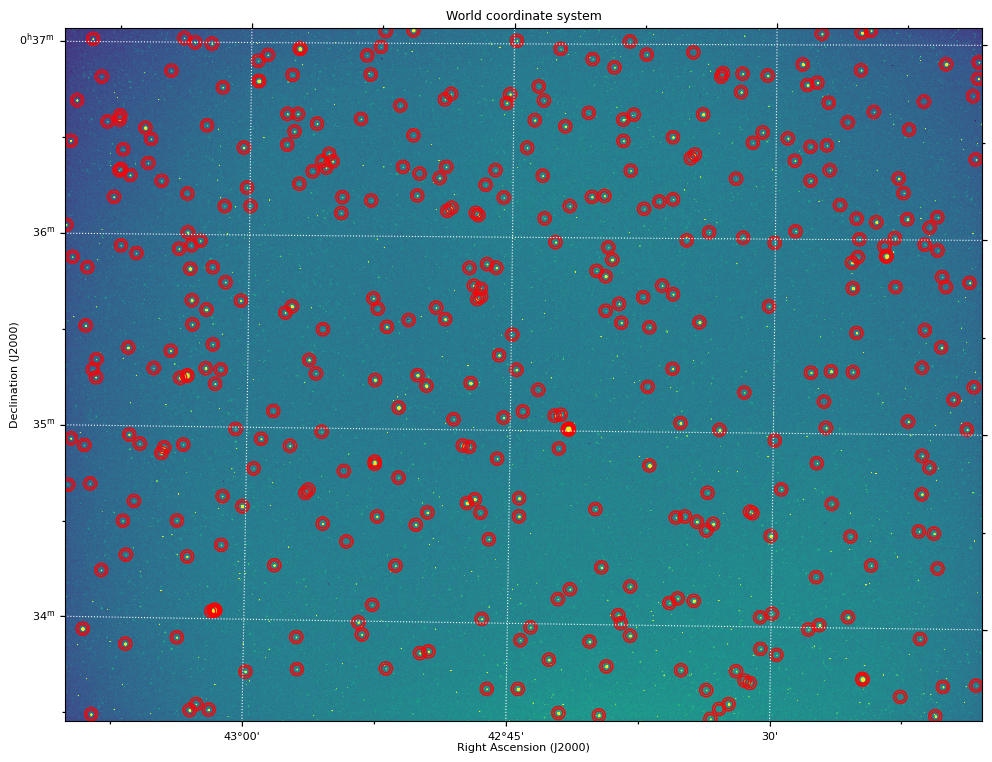

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=val_figsize,
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = _astro_utilities.zimshow(axs, hdul[0].data, )
axs.set_title('World coordinate system', fontsize=9)
axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('bl')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('bl')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')
axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

an_DAO.plot(axs, color="r")
for i in range(len(pos_DAO_pix)):
    axs.text(pos_DAO_pix[i][0], pos_DAO_pix[i][1], f"Star #{str(i)}", fontsize=6, color='w')

an_DAO.plot(axs, color="r")

cbar = plt.colorbar(im, ax = axs, fraction=0.035, pad=0.04, )
cbar.ax.tick_params(labelsize=8)

axs.set_title(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

axs.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

axs.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

# plt.show()
# plt.close()

In [ ]:
# apphot_result = apphot(hdul[0].data, apert, method='center')
# print(type(apphot_result))
# # df_apphot = pd.DataFrame()
# # apphot_result
# df_apphot = apphot_result.to_pandas()
# print(type(df_apphot))
# df_apphot

# ap_area  = apert.area
# ap_area

# # since our `annul` has many elements,
# mask_apert = (apert.to_mask(method='center'))
# mask_annul = (annul.to_mask(method='center'))

# mag_ann  = np.zeros(len(apphot_result))
# merr_ann = np.zeros(len(apphot_result))

In [ ]:
df_apphot = ypu.apphot_annulus(hdul[0].data, ap_DAO, an_DAO, error=yfu.errormap(hdul[0].data))
df_apphot['filename'] = fpath.stem
df_apphot['t_start'] = t_start
df_apphot['t_expos'] = t_expos
df_apphot['t_middle'] = t_middle
df_apphot['filter'] = flt
df_apphot["zeropt_med"] = zeropt_med

df_apphot["e_zeropt"] = dzeropt

df_apphot[f"{flt}_magnitude"] = df_apphot["mag"] - df_apphot["zeropt_med"]
df_apphot[f"{flt}_magerr"] = np.sqrt((dzeropt)**2+(df_apphot['merr'][0])**2)

sky_coord = wcs.pixel_to_world(df_apphot['xcenter'], df_apphot['ycenter'])
if verbose == True :
    print("sky_coord:", sky_coord)
    print("type(sky_coord)", type(sky_coord))
df_RADEC = pd.DataFrame({"RAJ2000": sky_coord.ra.degree, "DEJ2000": sky_coord.dec.degree})

df_apphot = pd.concat([df_apphot, df_RADEC], axis=1,)

df_apphot.to_csv(f"{DIFFPRESULTDIR}/{fpath.stem}_result_DAO_photometry.csv")

sky_coord: <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(8.38030831, 42.5561489 ), (8.3880763 , 42.34305219),
     (8.38262992, 42.66193755), (8.37262631, 43.14290857),
     (8.38478836, 42.70028378), (8.38042869, 43.04973804),
     (8.38142799, 43.0317427 ), (8.39321711, 42.5479905 ),
     (8.38847323, 43.04366806), (8.39967535, 42.53915666),
     (8.4122708 , 42.37647275), (8.41738453, 42.5605012 ),
     (8.4146064 , 42.76858029), (8.41514636, 42.73900709),
     (8.42581857, 42.33624654), (8.42807944, 42.3046853 ),
     (8.42750589, 42.51932216), (8.43048963, 42.52437566),
     (8.43383923, 42.41255838), (8.43476106, 42.41258283),
     (8.43185572, 42.99756422), (8.44238377, 42.53248016),
     (8.44271444, 42.58474539), (8.43609993, 42.94882674),
     (8.43895337, 42.86449171), (8.44617435, 42.65551123),
     (8.4536568 , 42.71012836), (8.46419141, 42.4944334 ),
     (8.45958116, 42.8323649 ), (8.46203267, 42.82442873),
     (8.47161483, 42.50966509), (8.46554018, 43.111825

In [20]:
df_apphot_sub = df_apphot.dropna()
print(len(df_apphot_sub))
df_apphot_sub = df_apphot_sub.loc[(df_apphot_sub["merr"] < ERR_Minimum)]
print(len(df_apphot_sub))
df_apphot_sub

391
381


,id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,ssky,nsky,nrej,aparea,...,t_start,t_expos,t_middle,filter,zeropt_med,e_zeropt,V_magnitude,V_magerr,RAJ2000,DEJ2000
0,1,2358.050894,5.812844,1.711123e+06,1308.099134,14704.001023,213.602601,600,4,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,14.417797,0.0606,8.380308,42.556149
1,2,3179.630710,15.660987,1.836100e+06,1355.027702,14438.874646,221.085258,809,4,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,12.854778,0.0606,8.388076,42.343052
2,3,1950.421157,18.772901,1.904551e+06,1380.054651,14712.190518,207.990585,913,1,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,12.670637,0.0606,8.382630,42.661938
3,4,95.811538,22.888225,1.836339e+06,1355.115750,14027.047704,226.684090,998,5,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,12.629573,0.0606,8.372626,43.142909
4,5,1802.722041,27.234561,2.160314e+06,1469.800686,14683.773190,208.747580,997,5,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,11.877466,0.0606,8.384788,42.700284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,387,2765.451783,2508.986787,1.746638e+06,1321.604505,14201.891641,215.540601,991,4,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,13.255317,0.0606,9.264382,42.457355
387,388,2911.700107,2512.213340,2.343611e+06,1530.885653,14156.360141,222.820703,905,6,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,11.447227,0.0606,9.265643,42.419245
388,389,1172.035460,2518.619221,1.640283e+06,1280.735399,14279.663441,212.630888,728,1,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,15.116636,0.0606,9.265685,42.872593
389,390,2944.592672,2520.486326,1.749081e+06,1322.528269,14116.185150,214.846807,680,6,113.097336,...,2024-10-01T20:43:46.264,100.0,2024-10-01T20:44:36.264,V,-26.124062,0.013308,13.165332,0.0606,9.268576,42.410686


In [ ]:
df_apphot_sub.columns

Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'msky', 'sky_std', 'nsky',
       'nrej', 'flux_star', 'flux_err', 'mag_ann', 'merr_ann', 'filename',
       't_start', 't_expos', 't_middle', 'filter', 'zeropt_med', 'zeropt_avg',
       'e_zeropt', 'V_magnitude', 'RAJ2000', 'DEJ2000', 'RAJ2000', 'DEJ2000'],
      dtype='object')

In [21]:
_astro_utilities.plot_differential_photometry_result(df_apphot_sub, fpath, 
                                                            flt, Mag_target, Mag_delta, 
                                                            DIFFPRESULTDIR)